We shall start by importing the essential libraries.

In [1]:
### IMPORTING LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
pd.options.mode.chained_assignment = None
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor, plot_tree

Next, we clean the data and bring it to a form which will make the model building process easy. This phase is done exactly the same way as in 00 - Flight Fare EDA.

In [2]:
### DATA PREPARATION
flightfare = pd.read_excel('C:\\Users\\Shekhar Lamba\\Desktop\\Python\\Projects\\Flight\Data_Train.xlsx')

df = pd.DataFrame(flightfare)

df['Destination'] = df['Destination'].replace('New Delhi', 'Delhi')

df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'], format = '%d/%m/%Y')

df['Weekday_of_Journey'] = df['Date_of_Journey'].dt.weekday
df['Day_of_Journey'] = df['Date_of_Journey'].dt.day
df['Month_of_Journey'] = df['Date_of_Journey'].dt.month
df.drop(['Date_of_Journey'], axis = 1, inplace = True)

df['Weekend_Journey'] = np.where(df['Weekday_of_Journey'] >= 5, 1, 0)
df.drop(['Weekday_of_Journey'], axis = 1, inplace = True)

df['Dep_Hour'] = pd.to_datetime(df['Dep_Time'], format = '%H:%M').dt.hour
df['Dep_Mins'] = pd.to_datetime(df['Dep_Time'], format = '%H:%M').dt.minute
df.drop(['Dep_Time'], axis = 1, inplace = True)

df['Next_Day_Arrival'] = 0
row_range = range(0, len(df))
for row in row_range: 
    df['Next_Day_Arrival'][row] = np.where((len(df['Arrival_Time'][row]) > 5), 1, 0)

df['Arrival_Hour'] = pd.to_datetime(df['Arrival_Time']).dt.hour
df['Arrival_Mins'] = pd.to_datetime(df['Arrival_Time']).dt.minute
df.drop(['Arrival_Time'], axis = 1, inplace = True)

row_range = range(0, len(df))
for row in row_range:
    if(len(df['Duration'][row]) <= 3):
        if 'h' in df['Duration'][row]:
            df['Duration'][row] = df['Duration'][row] + ' 0m'
        elif 'm' in df['Duration'][row]:
            df['Duration'][row] = '0h ' + df['Duration'][row]

df['Duration_in_minutes'] = 0
row_range = range(0, len(df))
for row in row_range:
    df['Duration_in_minutes'][row] = (int(df['Duration'][row].split('h ')[0]) * 60) + int(df['Duration'][row].split('h ')[1].replace('m', ''))

df.drop(['Duration'], axis = 1, inplace = True)

df['Flight_Route'] = 0
x_values = range(0, len(df))
for x in x_values:
    route = str(df['Route'][x])
    stops = route.count('→')
    if (stops == 1):
        df['Flight_Route'][x] = 'Direct'
    else:
        df['Flight_Route'][x] = df['Route'][x]

top_routes = df['Flight_Route'].value_counts().index[:6]
df['Flight_Route'] = np.where(df['Flight_Route'].isin(top_routes), df['Flight_Route'], 'Other')

df.drop(['Route'], axis = 1, inplace = True)
df.drop(['Additional_Info'], axis = 1, inplace = True)

df['Weekend_Journey'] = df['Weekend_Journey'].astype('int64')

df = df.dropna()

num_vars = df.select_dtypes(include = ['int64'])
cat_vars = df.select_dtypes(include = ['object'])
feature_names = collections.defaultdict(str)
for name in num_vars.columns:
    feature_names[name]
for name in cat_vars.columns:
    feature_names[name]
feature_names

pair = num_vars[['Price', 'Duration_in_minutes']]

for col in df.columns:
    if col in pair.columns:
        percentile = df[col].quantile([0.05, 0.95]).values
        df[col] = df[col].clip(lower = percentile[0], upper = percentile[1])

stops_mapper = {'non-stop': 0,
         '1 stop': 1,
         '2 stops': 2,
         '3 stops': 3,
         '4 stops': 4}
df['Total_Stops'] = df['Total_Stops'].replace(stops_mapper)

df['Flight_Route'] = df['Flight_Route'].replace(['DEL → BOM → COK', 'CCU → BOM → BLR', 'CCU → DEL → BLR', 'BLR → BOM → DEL',
                                                'DEL → HYD → COK'], ['Route_1', 'Route_2', 'Route_3', 'Route_4', 'Route_5'])
df = df.rename(columns = {'Flight_Route': 'Route'})

df_final = pd.get_dummies(df, columns = ['Airline', 'Source', 'Destination', 'Route'], drop_first = True)

Now we separate the independent and dependent features; we label them X and y respectively. Then, we separate data for training and testing sets in the ratio of 8:2.

In [3]:
### SEPARATING TRAIN AND TEST SETS
X = df_final.drop(['Price'], axis = 1)
y = df_final['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 99)

We now go on to make a simple Decision Tree model, which will serve as our baseline. We then fit the training data to this model and use it to get predictions for the testing set. We then calculate the following metrics:

1. MAE: It stands for Mean Absolute Error. It is calculated by taking the mean of the absolute difference between the dependent variable values and their respective predicted values acquired from the model.
2. RMSE: It stands for Root Mean Squared Error. It is calculated by first taking the difference between the dependent variable values and their respective predicted values acquired from the model, then squaring each of them and taking the square root of their mean value. 
3. R-Squared: It is the proportion of variation in the dependent variable which is explained by the independent variables.

For a good model, the MAE and RMSE values should be as low as possible while the R-Squared value should be closer to 1.

In [4]:
### CREATING A BASELINE MODEL AND CALCULATING ESSENTIAL METRICS
model_dt = DecisionTreeRegressor(random_state = 99)
model_dt.fit(X_train, y_train)
y_pred_dt = model_dt.predict(X_test)
print('MAE: %f' % mean_absolute_error(y_test, y_pred_dt))
print('RMSE: %f' % np.sqrt(mean_squared_error(y_test, y_pred_dt)))
print('R-Squared: %f' % r2_score(y_test, y_pred_dt))

MAE: 1174.502667
RMSE: 2020.010796
R-Squared: 0.725458


We see that MAE is about 1174.5 and RMSE is about 2020 which seem quite high. R-Squared is about 0.73 which means that right now, about 73% of the variation in price of flight tickets can explained by the independent features. Going forward, we shall try to improve these metrics.

In addition to these metrics, we shall also check if the errors are normally distributed. This is required for the error rates we are willing to accept when making decisions about the process. If the errors are not normal, incorrect decisions will be made more or less frequently than the stated confidence levels.

<Figure size 1152x864 with 0 Axes>

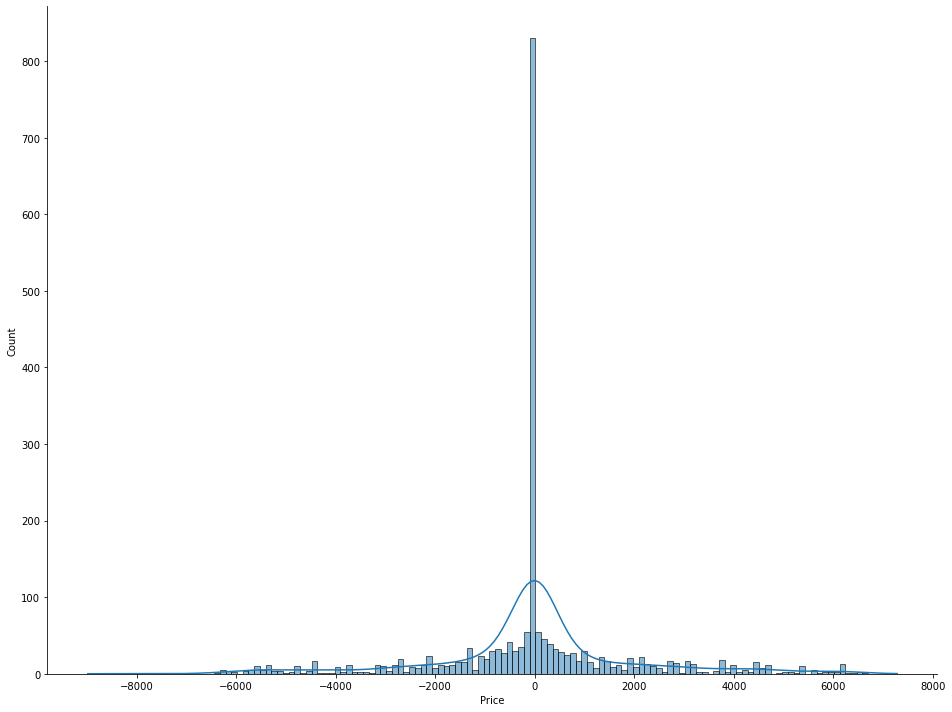

In [5]:
### PLOTTING THE ERRORS
plt.figure(figsize = (16, 12))
sns.displot(x = (y_test - y_pred_dt), height = 10, aspect = 8/6, kde = True)

The errors do not seem as normal as we want them to be, something we'll look to improve going forward.

We can also plot the tree model that we just made.

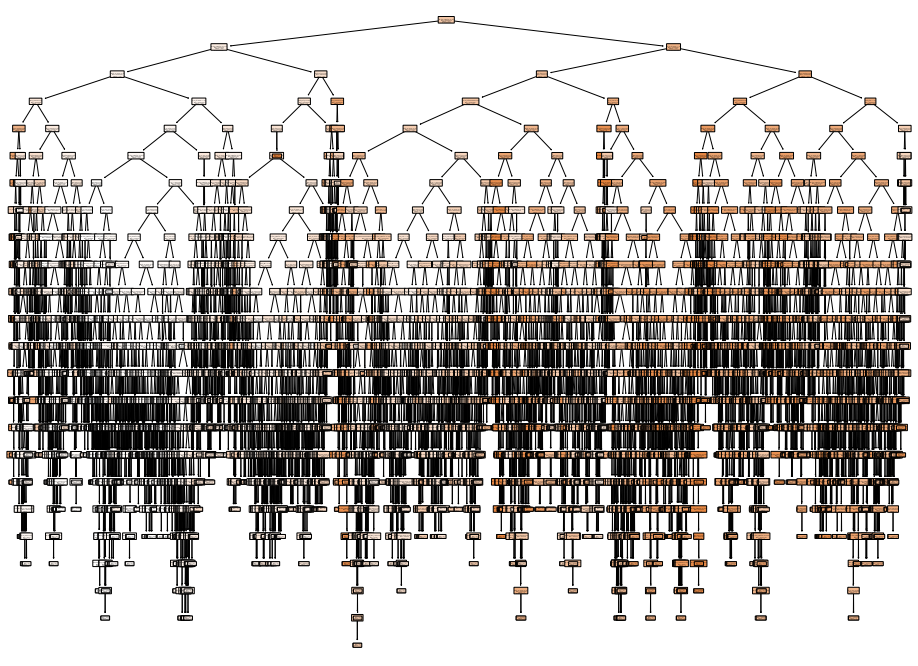

In [6]:
### PLOTTING THE TREE MODEL
plt.figure(figsize = (16, 12))
plot_tree(model_dt, rounded = True, filled = True, feature_names = X.columns);

We see that our baseline model is a huge tree which might have been overfit to the training data and thus led to poor performance on the testing data. To improve this, we can try to prune the tree to make it small so that it will fit well with new data. For this, we can make use of Cost Complexity Pruning. 


Suppose we have numerous trees of varying sizes- from a single leaf to the tree in the baseline model, then Cost Complexity Pruning assigns a Tree Score to each tree, where the score of a tree is calculated as the sum of it's SSRs and ccp_alpha times the total number of it's terminal nodes. The tree with the lowest Tree Score is considered to be the pruned tree. 


So, in order to prune the baseline tree model, we shall first need an ideal ccp_alpha value. For this, let us extract a range of possible values for ccp_alpha and then use them to create numerous models with which we can calculate the R-squared value for both the training and testing sets. We can plot these R-squared values on a graph against the ccp_alpha values.

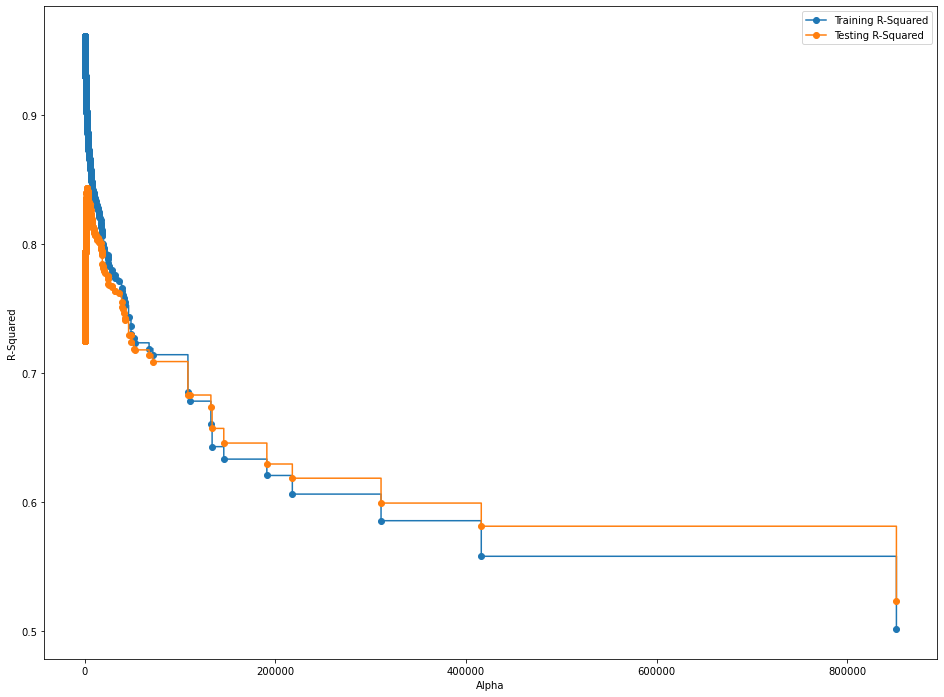

In [7]:
### PLOTTING R-SQUARED VALUES FOR TRAINING AND TESTING AGAINST CCP_ALPHA VALUES
path = model_dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1]
ccps = []
training_r2 = []
testing_r2 = []
for ccp_alpha in ccp_alphas:
    if ccp_alpha >= 0:
        tree = DecisionTreeRegressor(random_state = 99, ccp_alpha = ccp_alpha)
        model = tree.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        ccps.append(ccp_alpha)
        training_r2.append(r2_score(y_train, y_train_pred))
        testing_r2.append(r2_score(y_test, y_test_pred))
fig, ax = plt.subplots(figsize = (16, 12))
ax.set_xlabel('Alpha')
ax.set_ylabel('R-Squared')
ax.plot(ccps, training_r2, label = 'Training R-Squared', marker = 'o', drawstyle = 'steps-post')
ax.plot(ccps, testing_r2, label = 'Testing R-Squared', marker = 'o', drawstyle = 'steps-post')
ax.legend()
plt.show()

We can see the R-squared value for the testing data being about 85% in the interval 0 < ccp_alpha < 100000. Now, to find the ideal value, we shall use 5-fold cross validation on the training data with the mean R-squared value as the scoring parameter We store the average results from the cross validation on a dataframe and plot it on a graph against the ccp_alpha values.

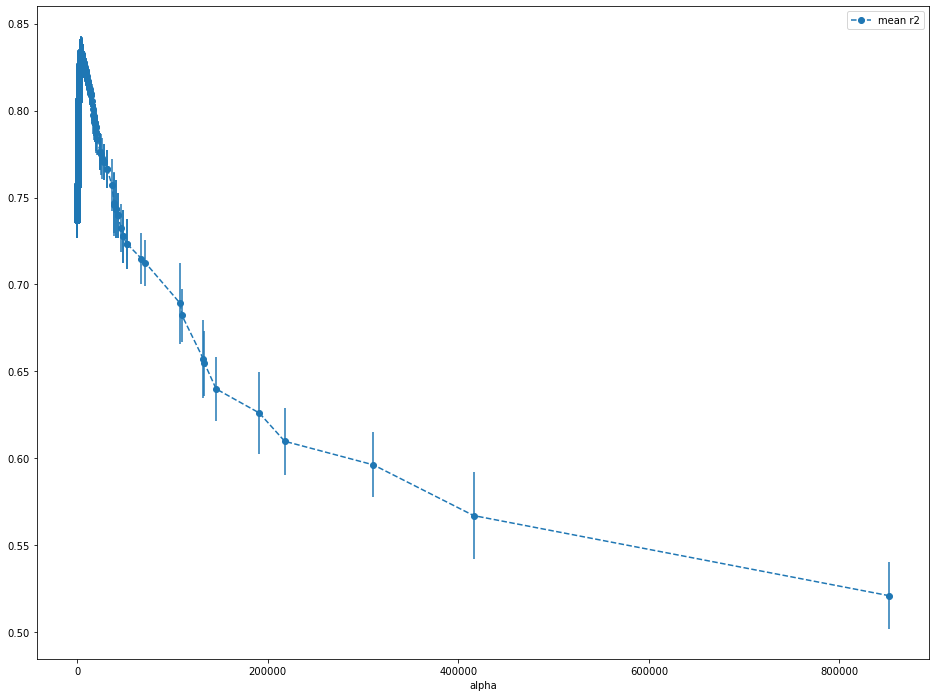

In [8]:
### PLOTTING THE CROSS VALIDATED R-SQUARED VALUES FOR TRAINING AGAINST CCP_ALPHA VALUES
alpha_loop_values = []
for ccp_alpha in ccps:
    tree = DecisionTreeRegressor(random_state = 99, ccp_alpha = ccp_alpha)
    scores = cross_val_score(tree, X_train, y_train, cv = 5, scoring = 'r2')
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])
alpha_results = pd.DataFrame(alpha_loop_values, columns = ['alpha', 'mean r2', 'std'])
fig, ax = plt.subplots(figsize = (16, 12))
alpha_results.plot(x = 'alpha',
                  y = 'mean r2',
                  yerr = 'std',
                  marker = 'o',
                  ax = ax,
                  linestyle = '--')
plt.show()

We see that the R-squared value reaches maximum within the range 0 < ccp_alpha < 100000. We shall consider the ccp_alpha corresponding to the largest R-squared score as our ideal ccp_alpha value.

In [9]:
### GETTING THE IDEAL CCP_ALPHA VALUE
ideal_ccp_alpha = float(alpha_results[alpha_results['mean r2'] == max(alpha_results['mean r2'])]['alpha'])
ideal_ccp_alpha

3164.336875784913

With this value, we shall prune the baseline model to get a new tree model.

In [10]:
### CREATING A PRUNED TREE MODEL AND CALCULATING ESSENTIAL METRICS
model_dt = DecisionTreeRegressor(random_state = 99, ccp_alpha = ideal_ccp_alpha)
model_dt.fit(X_train, y_train)
y_pred_dt = model_dt.predict(X_test)
print('MAE: %f' % mean_absolute_error(y_test, y_pred_dt))
print('RMSE: %f' % np.sqrt(mean_squared_error(y_test, y_pred_dt)))
print('R-Squared: %f' % r2_score(y_test, y_pred_dt))

MAE: 1110.310163
RMSE: 1544.722602
R-Squared: 0.839453


We see that the MAE has reduced from about 1174.5 to about 1110.31; RMSE has also reduced to about 1544.72 from it's initial value of about 2020. The R-Squared value has increased from about 0.73 to almost 0.84 which means that currently, 84% of the variation in price of flight tickets can be explained by the independent features. 


We can also plot the errors to see if they are normally distributed.

<Figure size 1152x864 with 0 Axes>

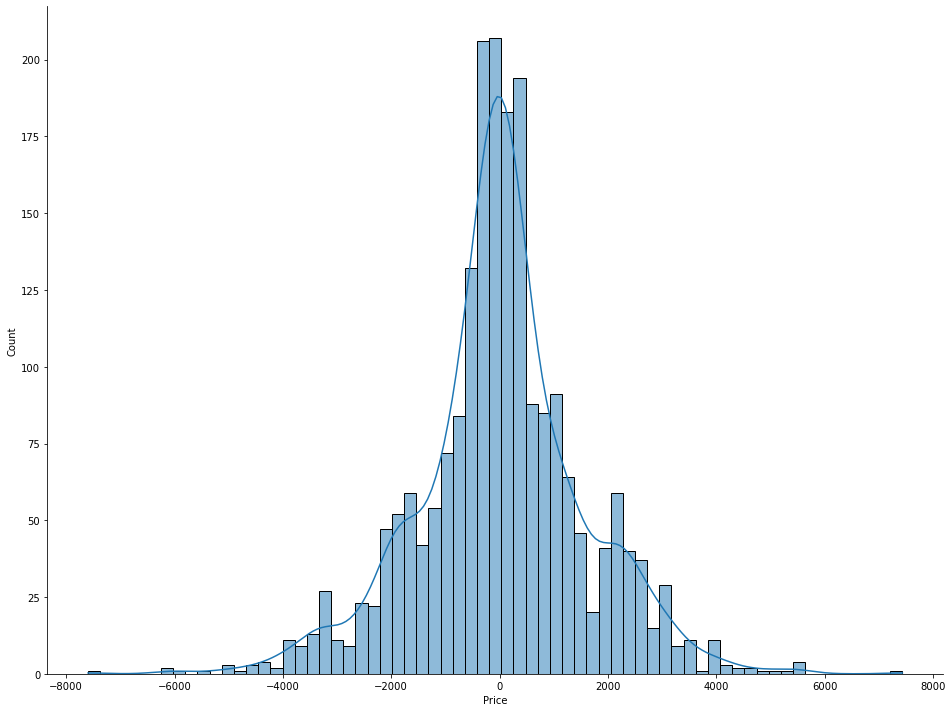

In [11]:
### PLOTTING THE ERRORS
plt.figure(figsize = (16, 12))
sns.displot(x = (y_test - y_pred_dt), height = 10, aspect = 8/6, kde = True)

This plot seems much closer to a normal distribution than the previous one.


We can also plot the new tree model.

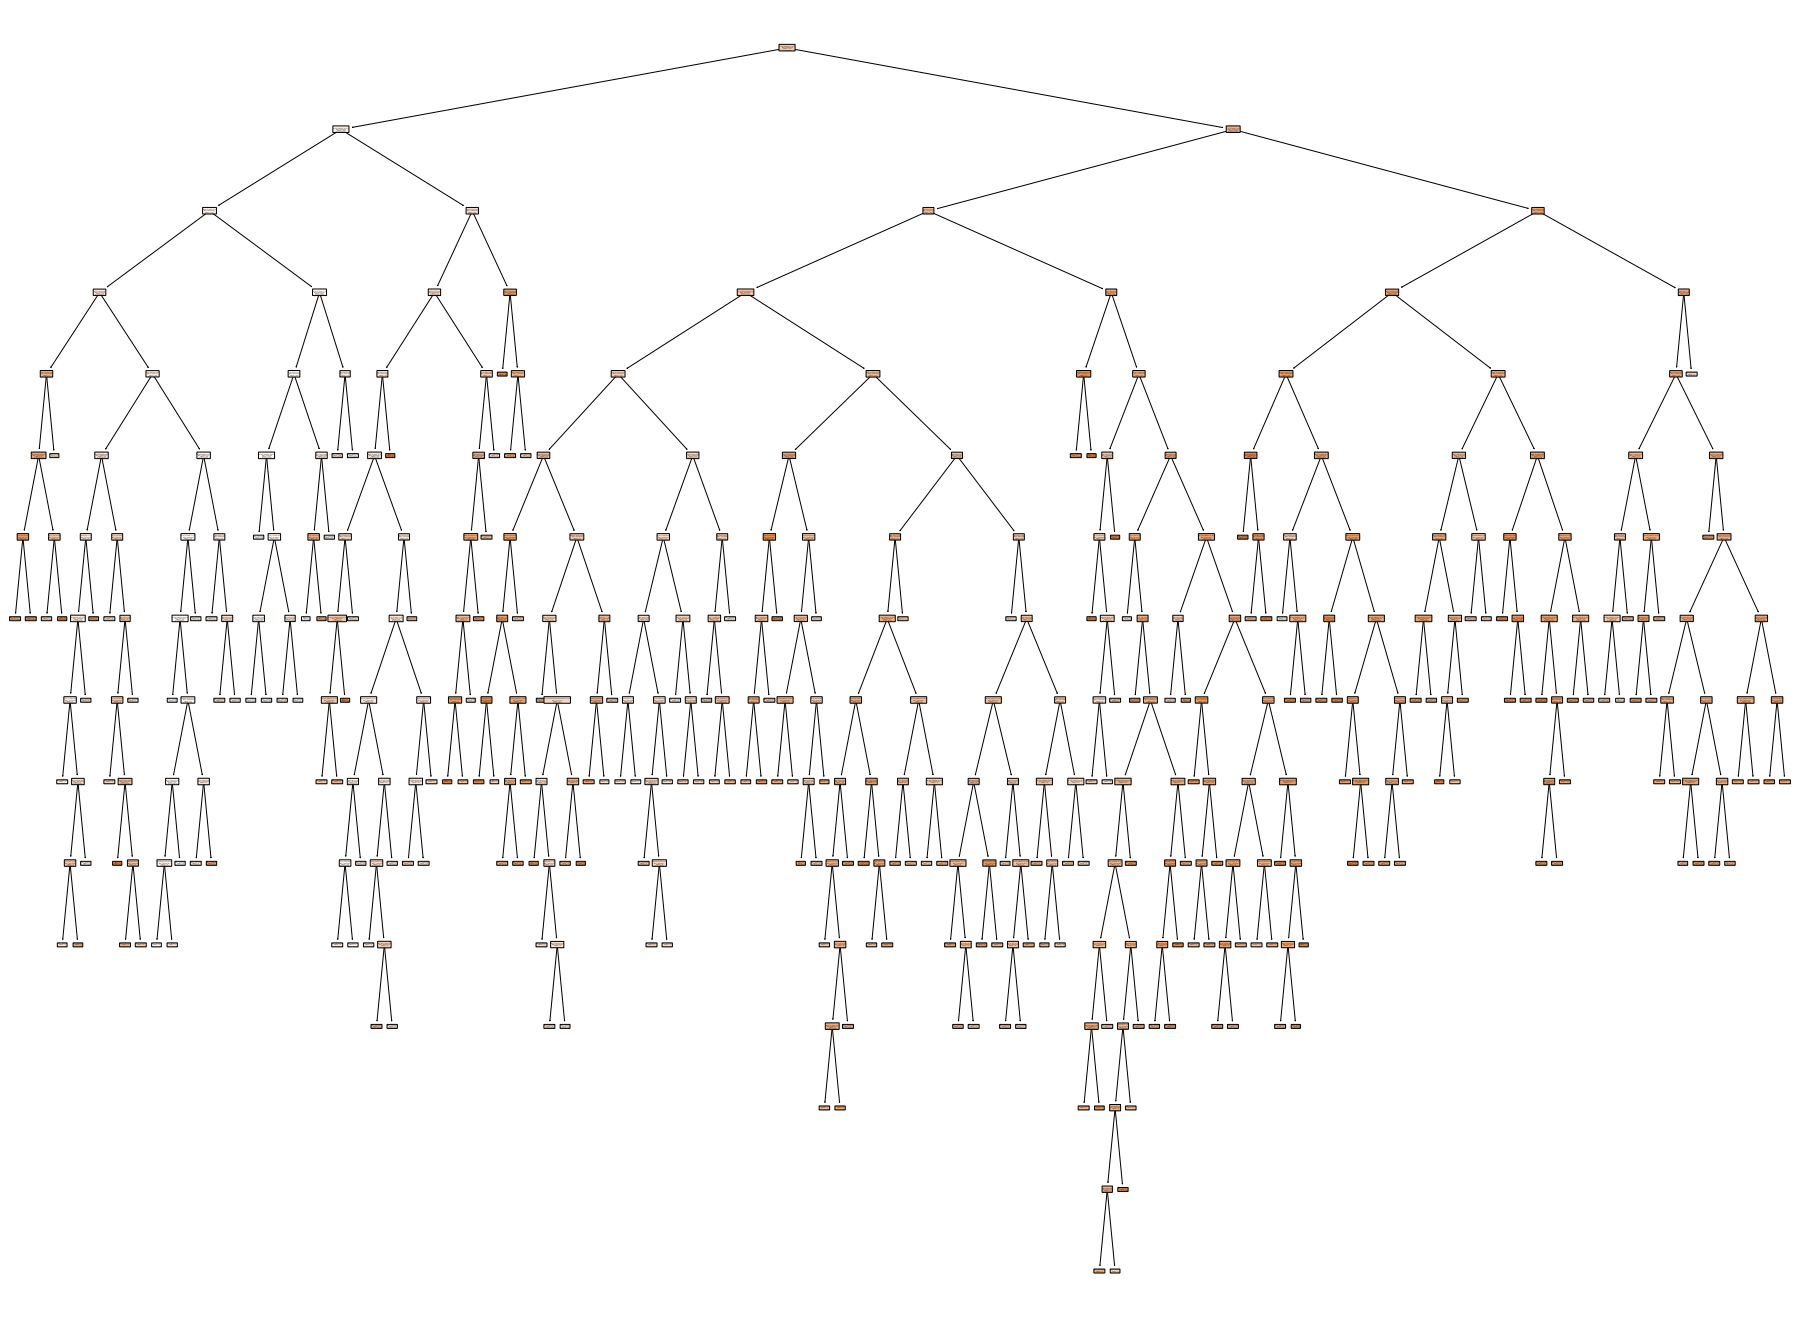

In [12]:
### PLOTTING THE TREE MODEL
plt.figure(figsize = (32, 24))
plot_tree(model_dt, rounded = True, filled = True, feature_names = X.columns);

Although this new tree seems less crowded than the previous one, it is still hard to interpret how it predicts the price of flight tickets. We can however restrict the depth of this tree to make it more interpretable. For this, we shall resort to hyperparameter tuning. 


We shall use a randomized search with 10 fold cross-validation across the possible values for the hyperparameters _'criterion'_ and _'max_depth'_. We will be using R-squared value as our scoring parameter. The hyperparameter _'criterion'_ is a function that measures the quality of a split. 

In [13]:
### TUNING HYPERPARAMETER VALUES USING RANDOMIZED SEARCH
param_distributions = {
    'criterion': ['squared_error', 'mse', 'friedman_mse', 'mae'],
    'max_depth': range(2, 15)
}
tree = DecisionTreeRegressor(random_state = 99, ccp_alpha = ideal_ccp_alpha)
random_fit = RandomizedSearchCV(estimator = tree,
                               param_distributions = param_distributions,
                               scoring = 'r2',
                               cv = 10,
                               n_iter = 10,
                               random_state = 99,
                               verbose = 2,
                               n_jobs = -1)
random_fit.fit(X_train, y_train)
print('Best r2: %f' % random_fit.best_score_)
print('Best criterion: %s' % random_fit.best_estimator_.get_params()['criterion'])
print('Best max_depth: %d' % random_fit.best_estimator_.get_params()['max_depth'])

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.7s


Best r2: 0.827623
Best criterion: mse
Best max_depth: 13


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   53.0s finished


Now, with these tuned hyperparameter values, we shall create our final Decision Tree model.

In [14]:
### CREATING THE FINAL MODEL AND CALCULATING ESSENTIAL METRICS
model_dt = DecisionTreeRegressor(random_state = 99, ccp_alpha = ideal_ccp_alpha, criterion = 'mse', max_depth = 13)
model_dt.fit(X_train, y_train)
y_pred_dt = model_dt.predict(X_test)
print('MAE: %f' % mean_absolute_error(y_test, y_pred_dt))
print('RMSE: %f' % np.sqrt(mean_squared_error(y_test, y_pred_dt)))
print('R-Squared: %f' % r2_score(y_test, y_pred_dt))

MAE: 1120.734492
RMSE: 1571.181559
R-Squared: 0.833906


We see that the MAE has slightly increased from about 1110.31 to about 1120.73; RMSE has also increased to about 1571.18 from about 1544.72. The R-Squared value has slightly decreased from almost 0.84 to almost 0.83 which means that currently, 83% the variation in price of flight tickets can explained by the independent features.

We can also plot the errors to see if they are normally distributed.

<Figure size 1152x864 with 0 Axes>

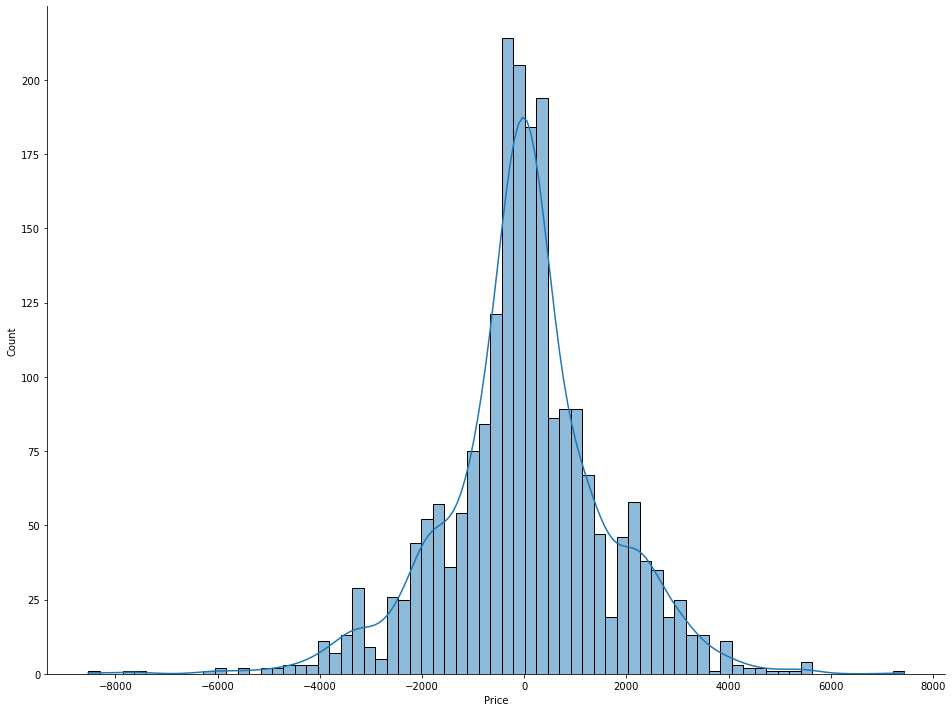

In [15]:
### PLOTTING THE ERRORS
plt.figure(figsize = (16, 12))
sns.displot(x = (y_test - y_pred_dt), height = 10, aspect = 8/6, kde = True)

We can see that the errors are still normally distributed.

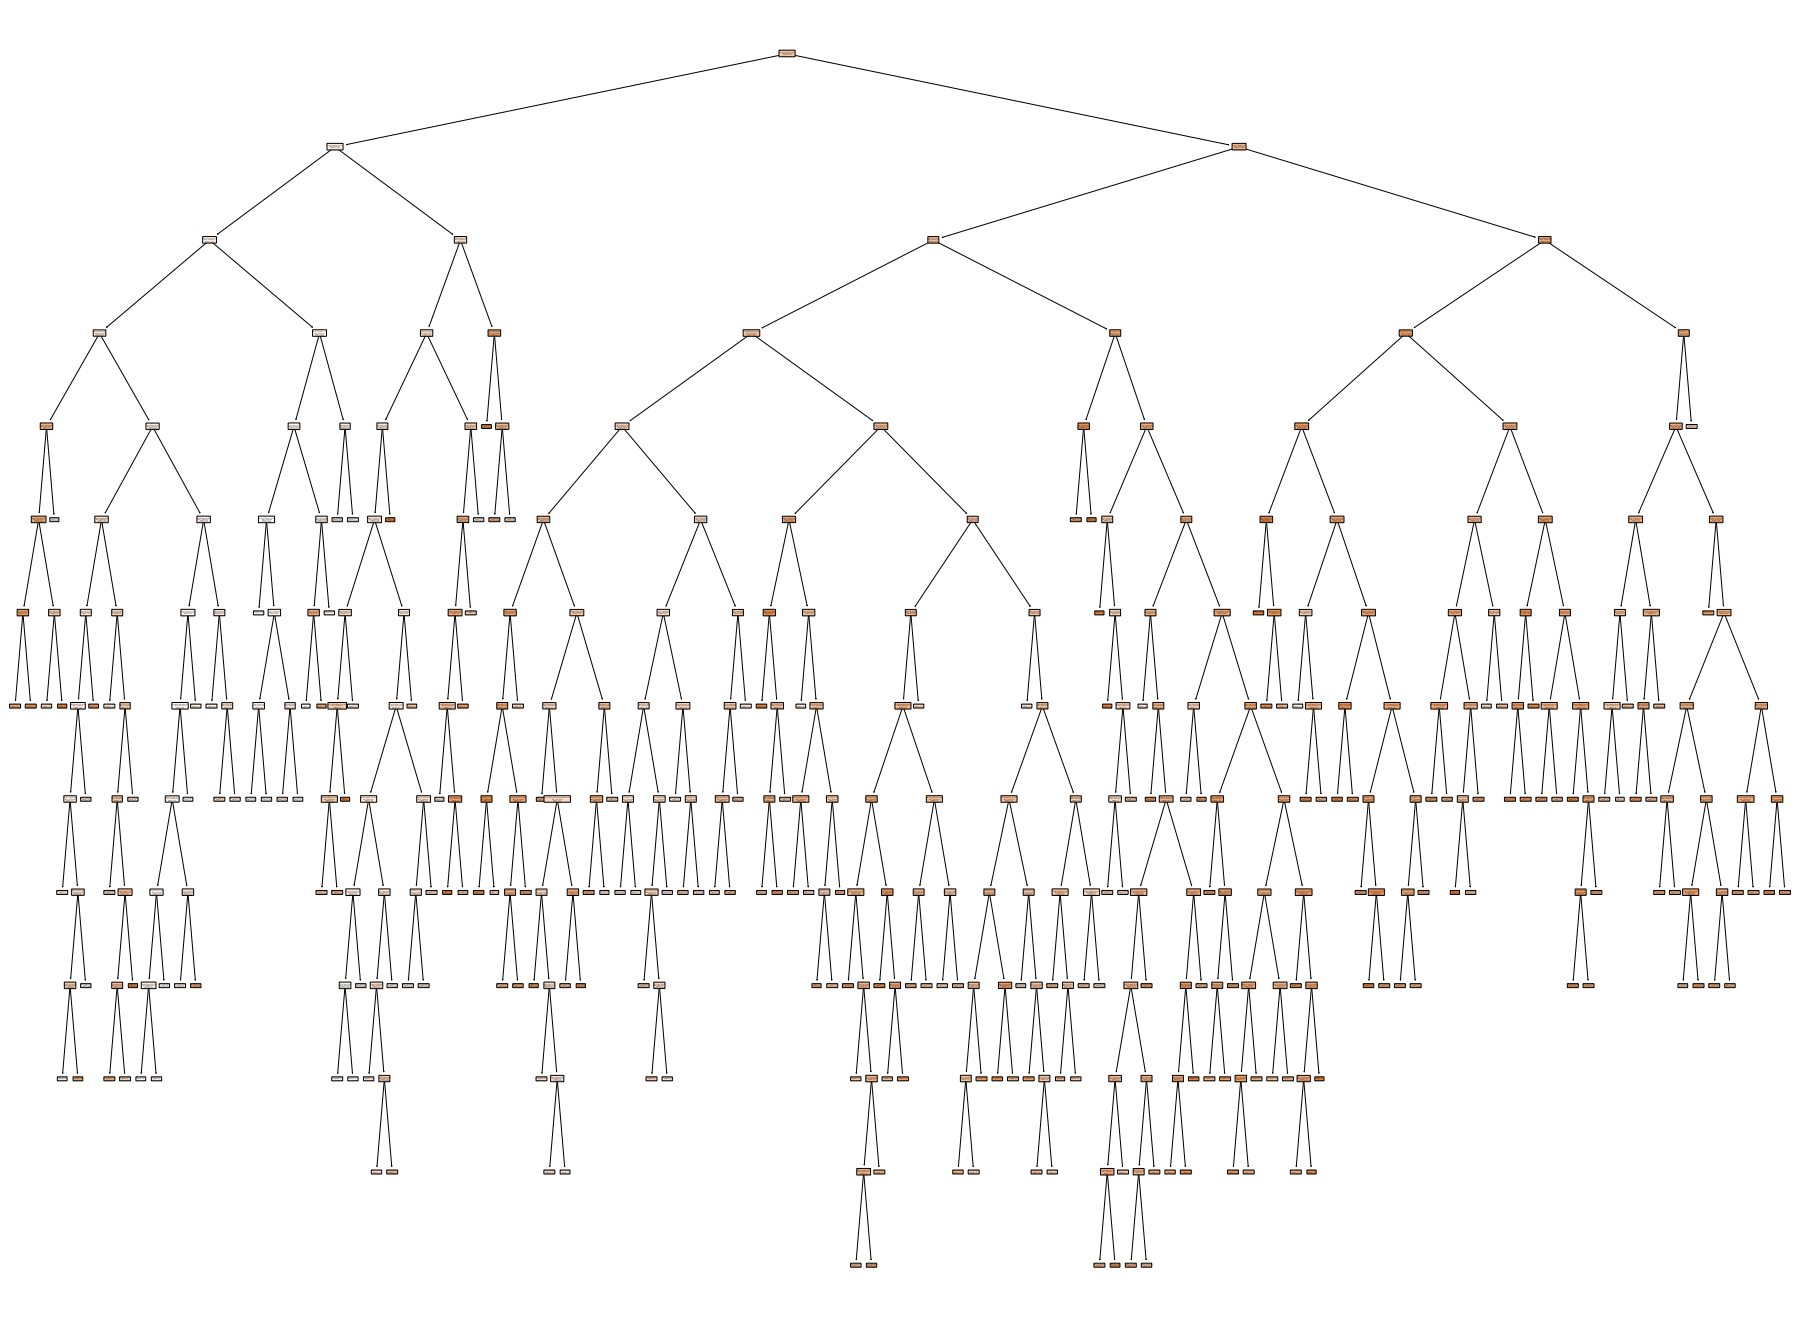

In [16]:
### PLOTTING THE TREE MODEL
plt.figure(figsize = (32, 24))
plot_tree(model_dt, rounded = True, filled = True, feature_names = X.columns);

The tree model is still not as interpretable as we want it to be even after restricting it's size. Furthermore, this final model is slightly worse than the second one in terms of the calculated metrics. Thus, we will select the second model as the best Decision Tree model.